### Pipeline optimization 
This code reads in a table of biogas sources -- including coordinates, estimated methane production costs (`$/MMBtu`), and pipeline delivery costs (`$/mi-MMBtu @15y`) -- and a cost surface, with units of mulitpliers (in percent) applied to building a section of pipeline through that cell. 

The code iterates through each biogas source and develops a least cost distance surface away from that source such that each pixel's value represents the aggregate cost to produce 1 MMbtu of methane and deliver it to that location. The result is a stack of these cost distance surfaces, one for each biogas source. 

The minimum value from the set of all cost distance surfaces represents the minimum cost to deliver methane to that site. It can be thresholded (identify all cells below a set minimum cost) to identify all areas that are cost effective to connect at a set price point. This would also identify other biogas sources that alone are not cost effective, but when considered alongside other sites, become cost effective. 

Summer 2019, john.fay@duke.edu

In [1]:
#Import packages
import numpy as np
import pandas as pd
from skimage import graph
from osgeo import gdal
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
#from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Read in cost surface data source
ds =  gdal.Open('../data/MIT_Surface_Subset/MIT_CostSurface_500m.img')
#Get the raster projection
ds_prj = ds.GetProjection()
#Get raster attributes
llx, x_size, x_angle, lly, y_angle, y_size = ds.GetGeoTransform()
#Extract Band1 as the cost array; divide by 100 to scale as a percentage
arrCost = np.array(ds.GetRasterBand(1).ReadAsArray()) / 100
#Print info
print("Lower left coordinate = ({0:.8f},{1:.8f})".format(llx,lly))
print("Pixel size is {0:.8f}(x), {1:.8f}(y)".format(x_size,y_size))
print("Values range from {} to {}".format(arrCost.min(),arrCost.max()))

Lower left coordinate = (1502530.32985527,-361423.20573852)
Pixel size is 500.00000000(x), -500.00000000(y)
Values range from 0.0 to 3.0


In [3]:
#Set zero cost multiplier to high costs (max X 10)
arrCost[arrCost == 0] = arrCost.max() * 10

In [4]:
#Read in biogas sources (example: Duplin Co)
dfBG =  pd.read_excel('../data/DuplinCountySwineFarmEconomics.xlsx',
                         sheet_name='Duplin County Swine Farm Master').iloc[:,[11,12,-6,-4,-1]]
#Sort values in ascending order by cost to pipe
dfBG.sort_values(by='TEST ($/mi-MMBtu @15y)',ascending=True,inplace=True)
dfBG.head()

,Farm Latitude,Farm Longitude,Total Potential Methane Yield (scf/h),Estimated Methane Production Cost ($/MMBtu),TEST ($/mi-MMBtu @15y)
141,34.8672,-78.1514,5450.830387,2.332976,0.019108
197,34.9131,-77.9531,5237.045262,2.630236,0.019736
163,34.8825,-78.1094,4274.978908,4.138270,0.023257
202,34.9228,-77.9597,3038.314870,6.675278,0.030653
55,34.7806,-78.1694,2948.403709,6.898455,0.031406


In [5]:
#Convert to a geopandas dataframe (for easy reprojecting)
geom = [Point(xy) for xy in zip(dfBG.iloc[:,1],dfBG.iloc[:,0])] #Create the geometry objects
gdfBG = gpd.GeoDataFrame(dfBG, geometry = geom)                 #Convert to a geodataframe
gdfBG.crs = {'init':'epsg:4326'}                                #Set the projection (NAD 1983)
#gdfBG.to_file('../data/DuplinSites_LL.shp')                     #Save to a file

In [6]:
#Re-project the points to match the raster (takes a moment...)
#gdfBG_prj = gdfBG.to_crs(ds_prj)
gdfBG_prj = gpd.read_file('../data/DuplinSites_Prj.shp')            #Alternatively, read in a saved, projected version

In [7]:
#Add columns for xOffset (columns) and yOffset (rows)
gdfBG_prj['xOffset'] = gdfBG_prj['geometry'].apply(lambda x: int(((x.x - llx)/x_size)))
gdfBG_prj['yOffset'] = gdfBG_prj['geometry'].apply(lambda x: int(((x.y - lly)/y_size))) 

In [8]:
#Iterate through all biogas site rows and create a cost distance raster
cd_arrays = []

for i,r in gdfBG_prj.iterrows():
    xOffset = r['xOffset']    #get the array x coordinate
    yOffset = r['yOffset']    #get the array y coordinate
    z = r[4] / 1609.34        #Get the pipeline cost (5th col) & convert from $/mile to $/meter
    base_cost = r[3]          #Get the base production cost (4th col)
    
    #Create the minimum cost path (MCP) surface
    lc_graph = graph.MCP_Geometric(arrCost * z , sampling=(x_size,y_size))
    #Compute cost distances away
    cd_array = lc_graph.find_costs(starts=([(yOffset, xOffset)]))[0]
    #Add the initial cost to all cells
    cd_array = cd_array + base_cost
    #Add to stack of arrays
    cd_arrays.append(cd_array)
        
#Create a stack of all arrays
arrStack =np.stack(cd_arrays)

In [10]:
#Save array stack to file
np.save('../data/DuplinStack.npy',arrStack)

In [11]:
#Export lowest cost farm to geotiff
bands,height,width = arrStack.shape
drv = gdal.GetDriverByName("GTiff")
dsOut = drv.Create('../scratch/lowest_cost.tif',width,height,1,gdal.GDT_Float32)

arrFirst = arrStack[0]
arrFirst[arrCost == 10] = -9999.9
dsOut.GetRasterBand(1).WriteArray(arrFirst)
dsOut.GetRasterBand(1).SetNoDataValue(-9999.9)
dsOut.SetGeoTransform (ds.GetGeoTransform())
dsOut.SetProjection(ds_prj)
dsOut.FlushCache()

In [12]:
#Create an array of the min of all surfaces and export to geotiff

#Reduce to minimum costs
arrMin = np.amin(arrStack,axis=0) 

#Assign -9999.9 to no data cells (where arrCost is Max)
arrMin[arrCost == arrCost.max()] = -9999.9

#Create the data source object
bands,height,width = arrStack.shape
drv = gdal.GetDriverByName("GTiff")
dsOut = drv.Create('../data/processed/min_cost_surface.tif',width,height,1,gdal.GDT_Float32)
dsOut.SetGeoTransform (ds.GetGeoTransform())  #Set the pixel size, offset, and warp
dsOut.SetProjection(ds_prj)                   #Define the coordinate system


#Write to the data source object
dsOut.GetRasterBand(1).WriteArray(arrMin)      #Write the data to the 1st band
dsOut.GetRasterBand(1).SetNoDataValue(-9999.9) #Assign NoData values
dsOut.FlushCache()

### Plotting

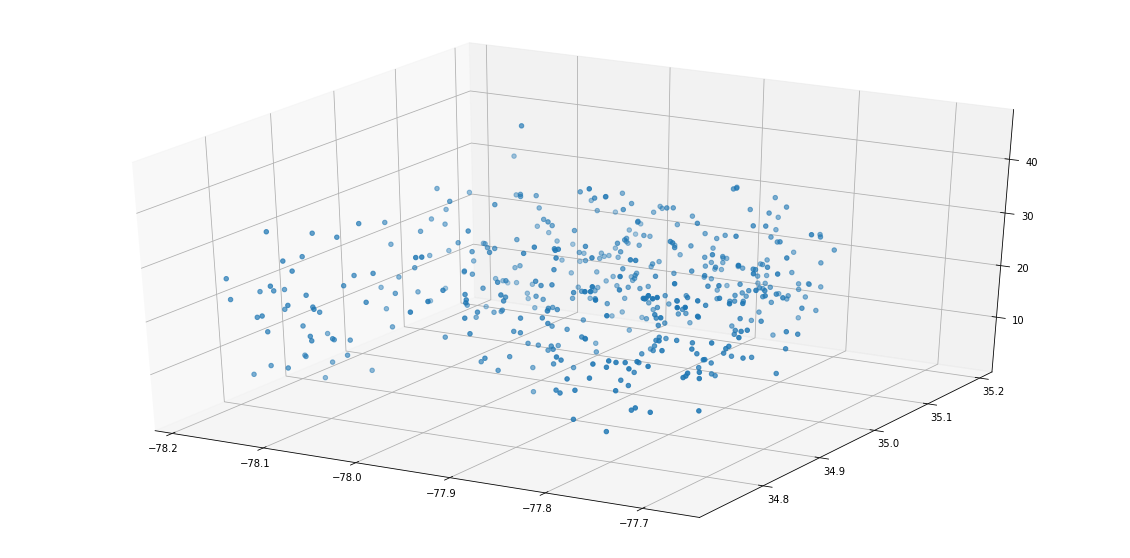

In [21]:
#Build 3d array of base cost values
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(gdfBG_prj.iloc[:,1],gdfBG_prj.iloc[:,0],gdfBG_prj.iloc[:,3], cmap='ocean');

In [14]:
#Create a 3 point for the lowest cost site
X1,Y1,Z1 = gdfBG_prj.iloc[0,[-2,-1,3]].values
#X1m,Y1m = np.meshgrid(X1,Y1)

In [15]:
#Create a mesh grid from the row and column
y = np.arange(0,arrMin.shape[0])
x = np.arange(0,arrMin.shape[1])
X,Y  = np.meshgrid(x,y)

#Create copies of the arrMin surface
arrMinCopy = arrMin.copy()
arrMinCopy[arrMin < 0]=np.NaN
arrMinCopy[arrMin > 5]=np.NaN
arrThreshold = np.full(arrMinCopy.shape,3)

C:\Users\jpfay\AppData\Local\ESRI\conda\envs\bg_optimi\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  


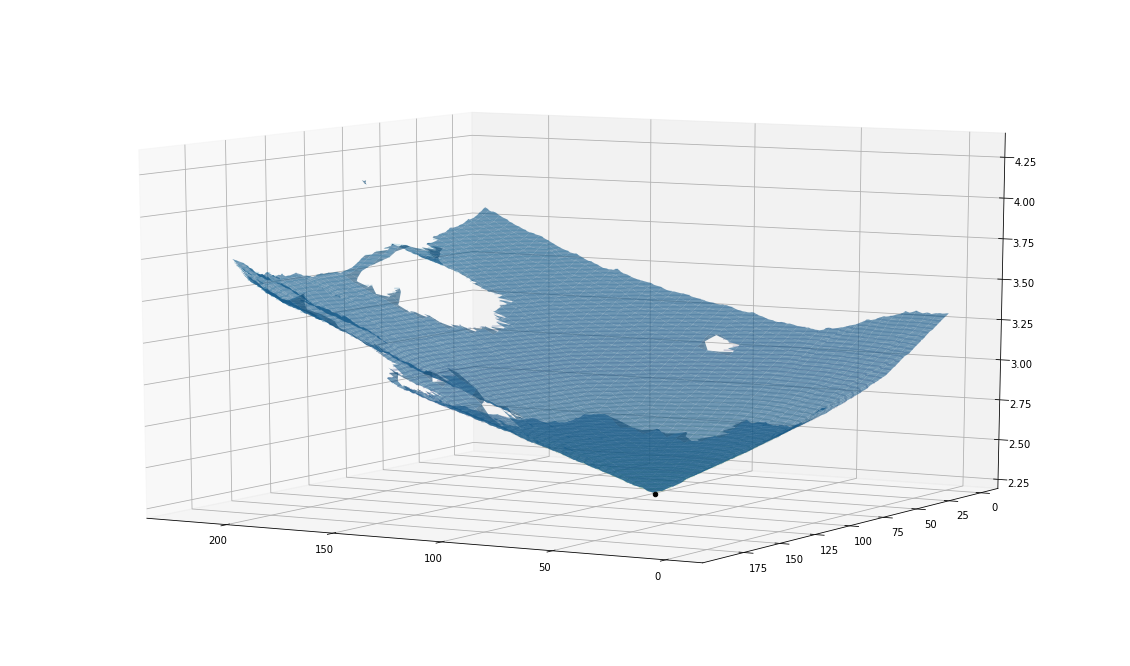

In [22]:
#3D plotting
fig = plt.figure(figsize=(20,12))            #Create the figure canvas
ax = fig.add_subplot(111, projection='3d')   #Add 3d plot...

ax.contour3D(X,Y,arrMinCopy,100,alpha=0.2,cmap='ocean')
ax.plot_surface(X,Y,arrMinCopy,linewidth=0,alpha=0.6)
#ax.plot_surface(X,Y,arrThreshold,linewidth=0,alpha=0.3)
#ax.scatter3D(X1m,Y1m,np.log(Z1),color='r')
#ax.scatter3D(X1,Y1,Z1,color='y')
#ax.scatter3D(gdfBG_prj.iloc[:,-2],gdfBG_prj.iloc[:,-1],gdfBG_prj.iloc[:,3], c=gdfBG_prj.iloc[:,3],cmap='Greens');
#ax.scatter3D(gdf.xOffset,dfBG.yOffset,dfBG['Estimated Methane Production Cost ($/MMBtu)'], cmap='ocean')
ax.scatter3D(gdfBG_prj.iloc[0,-2],gdfBG_prj.iloc[0,-1],gdfBG_prj.iloc[0,3], color='k');
ax.view_init(10,120);